In [1]:
import torch
import torch.nn as nn



In [2]:
!rm -rf /root/.cache/kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

Using Colab cache for faster access to the '70-dog-breedsimage-data-set' dataset.


In [ ]:
!unzip archive.zip

In [12]:
import os
from pathlib import Path
path = '/content'
folder = os.listdir(path + '/test')
print(folder)

['German Sheperd', 'Great Dane', 'Komondor', 'Great Perenees', 'Bull Mastiff', 'Irish Spaniel', 'Dalmation', 'Labrador', 'Beagle', 'Siberian Husky', 'Borzoi', 'Elk Hound', 'Bull Terrier', 'Poodle', 'Shar_Pei', 'Border Collie', 'American Hairless', 'Mex Hairless', 'Bluetick', 'Rhodesian', 'Cairn', 'Lhasa', 'Basset', 'Newfoundland', 'Groenendael', 'Cockapoo', 'Cocker', 'Greyhound', 'Chihuahua', 'Dingo', 'Chinese Crested', 'Boxer', 'Basenji', 'Shih-Tzu', 'Labradoodle', 'Collie', 'Doberman', 'Clumber', 'Pit Bull', 'Yorkie', 'Malinois', 'Rottweiler', 'Shiba Inu', 'Pekinese', 'African Wild Dog', 'Irish Wolfhound', 'Airedale', 'Scotch Terrier', 'French Bulldog', 'Bulldog', 'Schnauzer', 'Vizsla', 'American Spaniel', 'Chow', 'Bichon Frise', 'Maltese', 'Golden Retriever', 'Boston Terrier', 'Afghan', 'Pug', 'Pomeranian', 'Bloodhound', 'Dhole', 'Bermaise', 'Japanese Spaniel', 'Saint Bernard', 'Corgi', 'Bearded Collie', 'Blenheim', 'Coyote']


ВНИМАНИЕ!
Сначала упростим, решим только для 6 классов.

In [13]:
import shutil

accepted = ['Pug', 'Poodle', 'French Bulldog', 'Labrador', 'Golden Retriever', 'Corgi']

for i in ['train', 'valid', 'test']:
    for j in os.listdir(path + '/' + i):
        if j not in accepted:
            shutil.rmtree(path + '/' + i + '/' + j)

In [14]:
from torchvision import datasets, transforms

train_transformer = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

])

In [15]:
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(path + '/train', train_transformer)
val_dataset = datasets.ImageFolder(path + '/valid', test_transformer)
test_dataset = datasets.ImageFolder(path + '/test', test_transformer)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



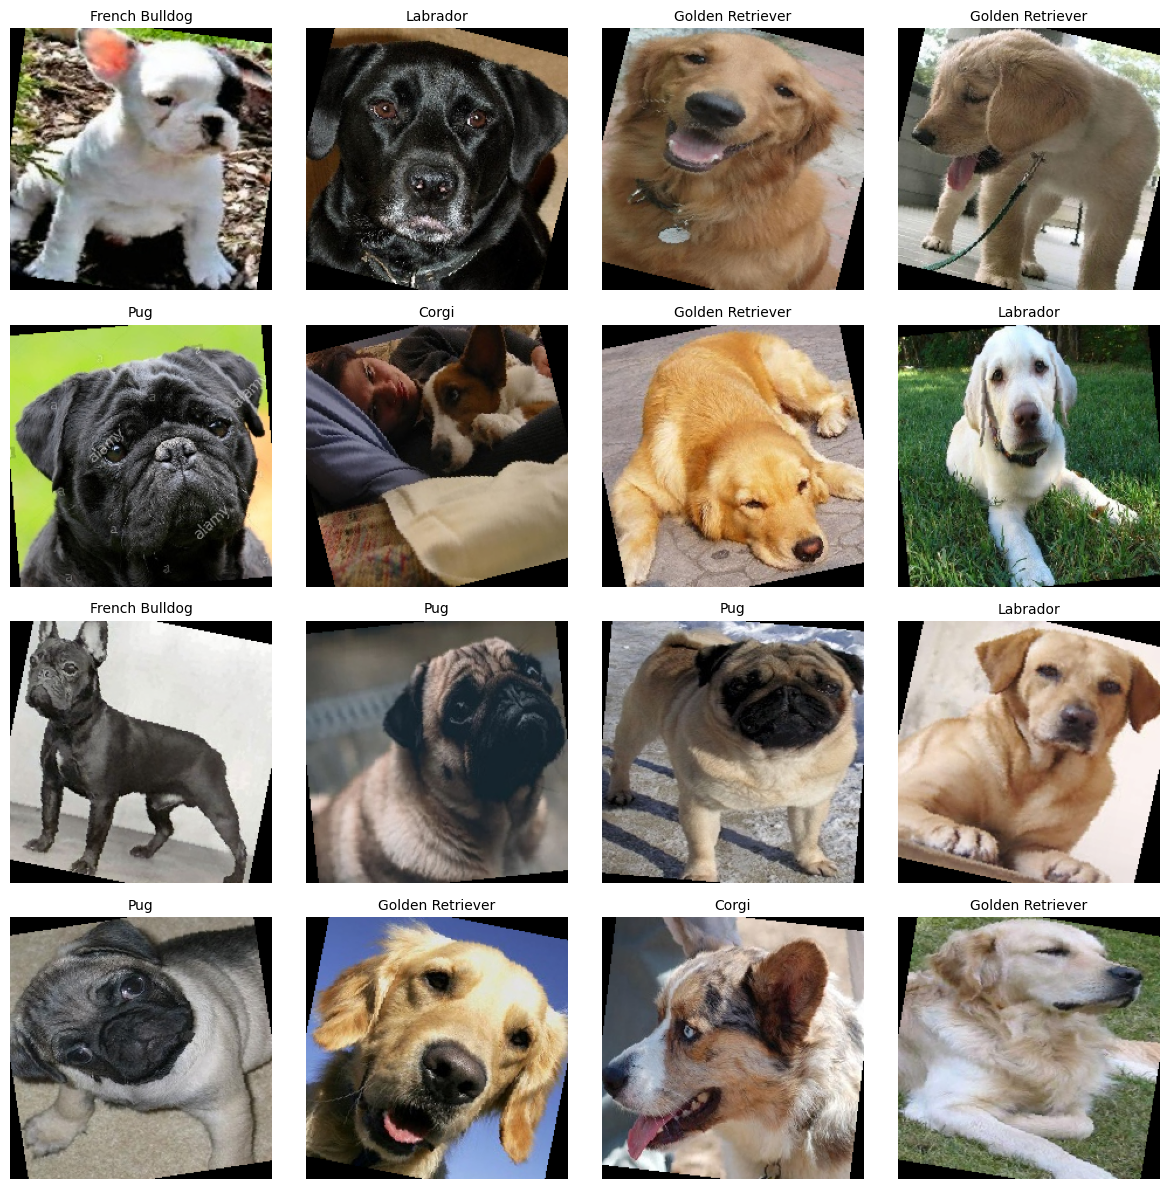

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def show_dog_breeds_basic(dataloader, class_names, num_images=16, images_per_row=4):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    num_images = min(num_images, len(images))
    images = images[:num_images]
    labels = labels[:num_images]

    rows = 4
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx in range(num_images):
        row = idx // cols
        col = idx % cols

        img = images[idx].numpy().transpose((1, 2, 0))
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{class_names[labels[idx]]}', fontsize=10)

    for idx in range(num_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


show_dog_breeds_basic(train_loader, train_dataset.classes, num_images=16)

In [20]:
import torch.nn.functional as F

class DogBreedCNN(nn.Module):
    def __init__(self, num_breeds=6, input_size=224):
        super(DogBreedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)


        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2)

        self.feature_size = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_breeds)



    def _get_conv_output(self, size):
        x = torch.randn(1, 3, size, size)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))


        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Использование
model = DogBreedCNN(num_breeds=70)
print(model)

DogBreedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=70, bias=True)
)



Тестируем LR = 1e-05
Средний loss: 4.3017

Тестируем LR = 0.0001
Средний loss: 4.5697

Тестируем LR = 0.001
Средний loss: 9.2286

Тестируем LR = 0.01
Средний loss: 25.2691

Тестируем LR = 0.1
Средний loss: 447.2785


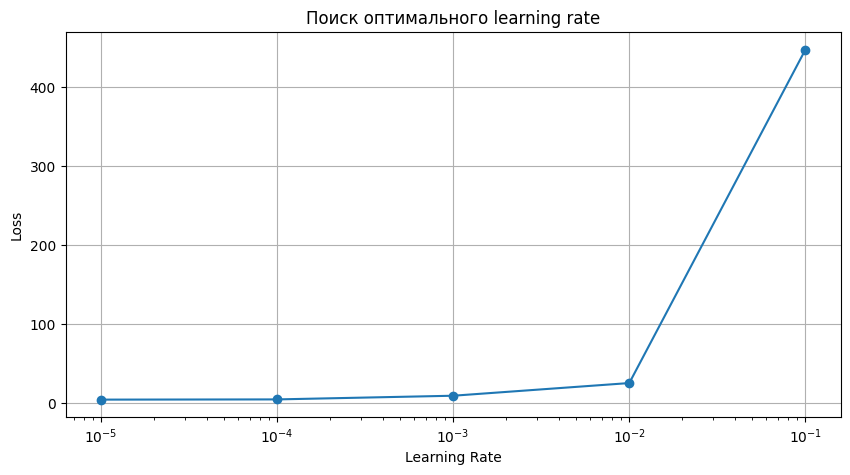


Лучший LR: 1e-05


1e-05

In [33]:
import matplotlib.pyplot as plt

def test_learning_rates(model, train_loader, lrs=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]):
    """
    Тестируем разные learning rates
    """
    results = {}

    for lr in lrs:
        print(f"\nТестируем LR = {lr}")

        # Создаем новый оптимизатор
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        losses = []

        # Тренируем на 5 батчах
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            if i > 5:
                break

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        results[lr] = avg_loss
        print(f"Средний loss: {avg_loss:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(list(results.keys()), list(results.values()), 'o-')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Поиск оптимального learning rate')
    plt.grid(True)
    plt.show()

    best_lr = min(results, key=results.get)
    print(f"\nЛучший LR: {best_lr}")
    return best_lr

test_learning_rates(model, train_loader)

In [24]:
from torchvision import models

class BreedClassifierResnet101(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT).eval()
        self.resnet = nn.Sequential(*list(model.children())[:-1])
        for parameter in self.resnet.parameters():
            parameter.requires_grad_(False)
        num_ftrs = model.fc.in_features
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, out_size)
        )
    def forward(self, x):
        x = self.resnet(x)
        return self.net(x)

EPOCH  1
TRAIN LOSS 2.101579397916794
TRAIN ACC 21.21212121212121
EPOCH  2
TRAIN LOSS 1.7280241772532463
TRAIN ACC 25.164690382081687
EPOCH  3
TRAIN LOSS 1.6494123091300328
TRAIN ACC 32.27931488801054
EPOCH  4
TRAIN LOSS 1.6323517685135205
TRAIN ACC 31.357048748353098
EPOCH  5
TRAIN LOSS 1.5790901333093643
TRAIN ACC 35.96837944664031
EPOCH  6
TRAIN LOSS 1.5213362375895183
TRAIN ACC 37.68115942028985
EPOCH  7
TRAIN LOSS 1.5116774141788483
TRAIN ACC 38.3399209486166
EPOCH  8
TRAIN LOSS 1.4688298826416333
TRAIN ACC 43.08300395256917
EPOCH  9
TRAIN LOSS 1.4296369105577469
TRAIN ACC 44.00527009222662
EPOCH  10
TRAIN LOSS 1.4042497177918751
TRAIN ACC 45.586297760210805
EPOCH  11
TRAIN LOSS 1.3675555835167568
TRAIN ACC 46.50856389986825
EPOCH  12
TRAIN LOSS 1.3181096911430359
TRAIN ACC 47.430830039525695
EPOCH  13
TRAIN LOSS 1.2976099538306396
TRAIN ACC 49.40711462450593
EPOCH  14
TRAIN LOSS 1.2758326344192028
TRAIN ACC 51.515151515151516
EPOCH  15
TRAIN LOSS 1.193238165229559
TRAIN ACC 53.49

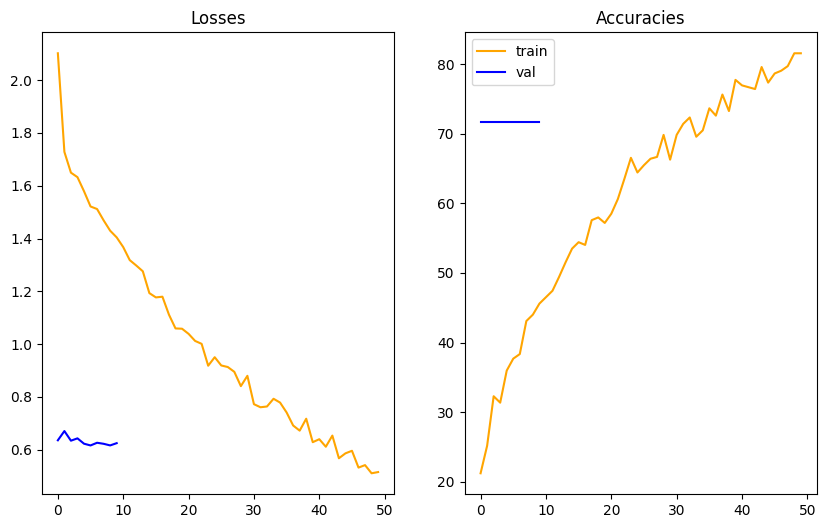

In [25]:
def train_epoch(model, train_loader, opt, criterion, epoch, device):
    epoch_loss = []
    correct = 0
    total = 0
    model.train()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_loss.append(loss.item())
        _, predicted = y_pred.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()

    print('EPOCH ', epoch + 1)
    print('TRAIN LOSS', np.mean(epoch_loss))
    print('TRAIN ACC', 100. * correct / total)
    return np.mean(epoch_loss), 100. * correct / total


def validate_epoch(model, val_loader, criterion, epoch, device):
    epoch_loss = []
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            epoch_loss.append(loss.item())
            _, predicted = y_pred.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

    print('EPOCH ', epoch + 1)
    print('VAL LOSS', np.mean(epoch_loss))
    print('VAL ACC', 100. * correct / total)
    return np.mean(epoch_loss), 100. * correct / total



criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = BreedClassifierResnet101(6).to(device)
model = DogBreedCNN(6).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)



train_losses = []
train_accs = []
for epoch in range(50):
    loss, acc = train_epoch(model, train_loader, opt, criterion, epoch, device)
    train_losses.append(loss)
    train_accs.append(acc)


val_losses = []
val_accs = []
for epoch in range(10):
    loss, acc = validate_epoch(model, val_loader, criterion, epoch, device)
    val_losses.append(loss)
    val_accs.append(acc)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(train_losses, color='orange', label='train')
plt.plot(val_losses, color='blue', label='val')
plt.title('Losses')
plt.subplot(122)
plt.plot(train_accs, color='orange', label='train')
plt.plot(val_accs, color='blue', label='val')
plt.title('Accuracies')
plt.legend()
plt.show()

EPOCH  1
TRAIN LOSS 1.4567427138487499
TRAIN ACC 67.3254281949934
EPOCH  2
TRAIN LOSS 0.8265833922972282
TRAIN ACC 88.14229249011858
EPOCH  3
TRAIN LOSS 0.49100352513293427
TRAIN ACC 92.2266139657444
EPOCH  4
TRAIN LOSS 0.33222908340394497
TRAIN ACC 94.99341238471673
EPOCH  5
TRAIN LOSS 0.23686533623064557
TRAIN ACC 96.31093544137022
EPOCH  6
TRAIN LOSS 0.22356791018197933
TRAIN ACC 94.86166007905139
EPOCH  7
TRAIN LOSS 0.18940907204523683
TRAIN ACC 96.44268774703558
EPOCH  8
TRAIN LOSS 0.1612268703368803
TRAIN ACC 96.57444005270092
EPOCH  9
TRAIN LOSS 0.13561916335796317
TRAIN ACC 97.23320158102767
EPOCH  10
TRAIN LOSS 0.11944105833147962
TRAIN ACC 97.23320158102767
EPOCH  11
TRAIN LOSS 0.1102635026909411
TRAIN ACC 98.55072463768116
EPOCH  12
TRAIN LOSS 0.13378371872628728
TRAIN ACC 95.91567852437417
EPOCH  13
TRAIN LOSS 0.11463138503798594
TRAIN ACC 97.62845849802372
EPOCH  14
TRAIN LOSS 0.10104215894049655
TRAIN ACC 97.23320158102767
EPOCH  15
TRAIN LOSS 0.0869484231613266
TRAIN ACC

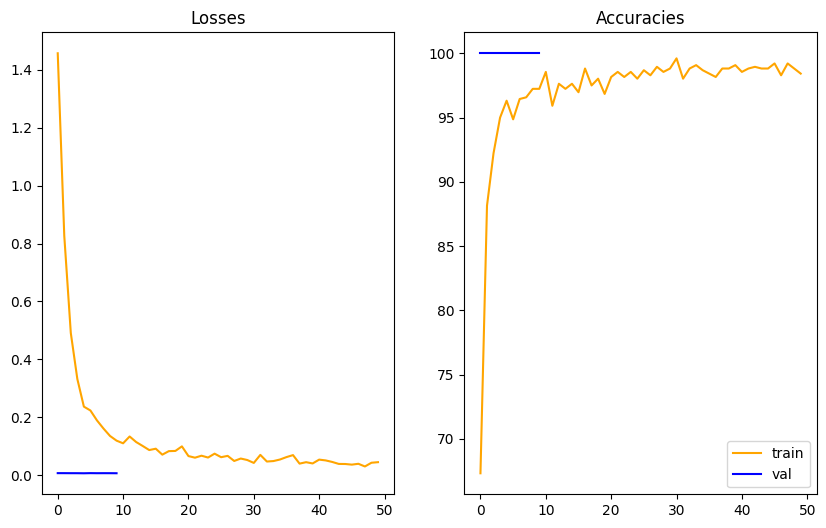

In [26]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BreedClassifierResnet101(6).to(device)
# model = DogBreedCNN(6).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)



train_losses = []
train_accs = []
for epoch in range(50):
    loss, acc = train_epoch(model, train_loader, opt, criterion, epoch, device)
    train_losses.append(loss)
    train_accs.append(acc)


val_losses = []
val_accs = []
for epoch in range(10):
    loss, acc = validate_epoch(model, val_loader, criterion, epoch, device)
    val_losses.append(loss)
    val_accs.append(acc)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(train_losses, color='orange', label='train')
plt.plot(val_losses, color='blue', label='val')
plt.title('Losses')
plt.subplot(122)
plt.plot(train_accs, color='orange', label='train')
plt.plot(val_accs, color='blue', label='val')
plt.title('Accuracies')
plt.legend()
plt.show()

ПОВТОРЯЕМ, НО ДЛЯ ВСЕХ 70 МЕТОК


In [28]:
!rm -rf test train valid

In [ ]:
!unzip archive.zip

EPOCH  1
TRAIN LOSS 2.9415451892664737
TRAIN ACC 52.793858545179965
EPOCH  2
TRAIN LOSS 1.0704533741987448
TRAIN ACC 81.52529574628744
EPOCH  3
TRAIN LOSS 0.6367843763029551
TRAIN ACC 85.14976088598037
EPOCH  4
TRAIN LOSS 0.5219328419963118
TRAIN ACC 86.63478479738234
EPOCH  5
TRAIN LOSS 0.4471595087641442
TRAIN ACC 87.80518499874151
EPOCH  6
TRAIN LOSS 0.40675075175296854
TRAIN ACC 88.19531839919456
EPOCH  7
TRAIN LOSS 0.3670653365402514
TRAIN ACC 89.57966272338284
EPOCH  8
TRAIN LOSS 0.3487855905978013
TRAIN ACC 89.5419078781777
EPOCH  9
TRAIN LOSS 0.3313226264937063
TRAIN ACC 90.78781776994714
EPOCH  10
TRAIN LOSS 0.31677288599537173
TRAIN ACC 90.38509942109238
EPOCH  11
TRAIN LOSS 0.30043080682216033
TRAIN ACC 90.80040271834885
EPOCH  12
TRAIN LOSS 0.29209558240379724
TRAIN ACC 90.98917694437453
EPOCH  13
TRAIN LOSS 0.2754015303975799
TRAIN ACC 91.56808457085326
EPOCH  14
TRAIN LOSS 0.25440266959639024
TRAIN ACC 92.2602567329474
EPOCH  15
TRAIN LOSS 0.2597152486488493
TRAIN ACC 91.

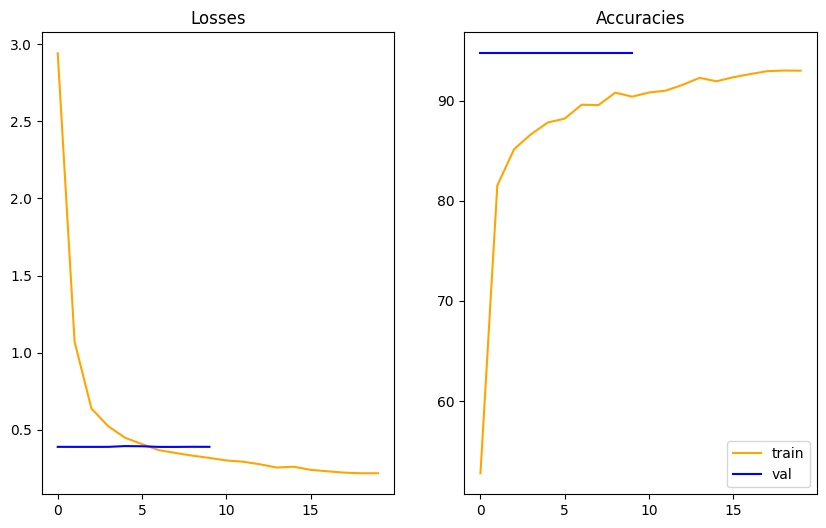

In [32]:
from torchvision import datasets, transforms

train_transformer = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

])

from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(path + '/train', train_transformer)
val_dataset = datasets.ImageFolder(path + '/valid', test_transformer)
test_dataset = datasets.ImageFolder(path + '/test', test_transformer)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BreedClassifierResnet101(70).to(device)
# model = DogBreedCNN(70).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)



train_losses = []
train_accs = []
for epoch in range(20):
    loss, acc = train_epoch(model, train_loader, opt, criterion, epoch, device)
    train_losses.append(loss)
    train_accs.append(acc)


val_losses = []
val_accs = []
for epoch in range(10):
    loss, acc = validate_epoch(model, val_loader, criterion, epoch, device)
    val_losses.append(loss)
    val_accs.append(acc)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(train_losses, color='orange', label='train')
plt.plot(val_losses, color='blue', label='val')
plt.title('Losses')
plt.subplot(122)
plt.plot(train_accs, color='orange', label='train')
plt.plot(val_accs, color='blue', label='val')
plt.title('Accuracies')
plt.legend()
plt.show()